In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

In [2]:
import torch

/Users/maxperozek/opt/anaconda3/envs/comp_gr_thy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from scipy.spatial.distance import cdist

In [4]:
from tqdm import tqdm

In [5]:
def euclid_dist(v1, v2):
    return np.linalg.norm(v1-v2)

0a) Optional: the example we did in class used photos of Buckaroo as the data we were trying to embed. Data available here:

In [6]:
import os

In [7]:
ims = []
root = '/Users/maxperozek/CP341/Day7/buck_images/'

for file in os.listdir(root):
    ims.append((imread(root+file), file))

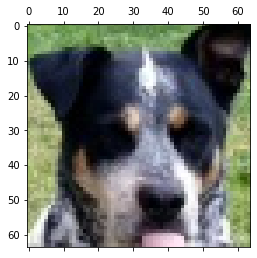

In [8]:
plt.matshow(ims[0][0])

In [9]:
def image_dist(im1, im2):
    flat_im1 = im1[:,:,0].reshape(-1,1) # reshapes to flat
    flat_im2 = im2[:,:,0].reshape(-1,1)
    return euclid_dist(flat_im1, flat_im2)

In [10]:
im_vecs = []
for im, filename in ims:
    im_vecs.append(im[:,:,0].reshape(-1,1))

In [11]:
im_matrix = np.array(im_vecs).astype(int)

In [12]:
im_matrix.reshape(-1,4096)

array([[116, 117, 112, ..., 135, 148, 136],
       [ 67,  91,  95, ..., 107, 139, 141],
       [142, 134, 127, ..., 148, 151, 146],
       ...,
       [ 34,  44,  33, ..., 132, 135, 146],
       [ 64,  87,  70, ..., 131, 136, 140],
       [ 49,  93,  75, ..., 127, 135, 143]])

In [13]:
im_matrix.shape

(701, 4096, 1)

In [14]:
im_matrix = np.squeeze(im_matrix)

0b) Implement one of the clustering algorithms we discussed today in class. You implementation should be reasonably 'from scratch'. This means that you can use numpy, scipy, sklearn as utility functions, but you shouldn't just use the KMeans implementation that alredy exists in any of those packages. Your clustering algorithm should take in a D x F matrix of data and a number of clusters, K, and produce an Dx1 vectors. The ith spot of this vector is a number between 0 and K-1 that indicates which cluster data point i is assigned to.

In [15]:
def agg_clus(data_matrix, n_clusters=2):
    
    # cluster assignment is a list with each index representing an assignment 
    cluster_assignment = np.arange(data_matrix.shape[0])
    
    pbar = tqdm(total = data_matrix.shape[0]-n_clusters, position=0, leave=True)
    while np.unique(cluster_assignment).shape[0] > n_clusters: # np.unique() removes duplicates from array
        used_labels = np.unique(cluster_assignment)
        # compute the distance betweeen each cluster
        # init the size of the cluster to cluster distances to be a dxd matrix with d = #clusters
        c2c_distances = np.zeros((used_labels.shape[0], used_labels.shape[0]))
        
        for i in range(used_labels.shape[0]):
            for j in range(used_labels.shape[0]):
                # get all features from examples that match cluster assignment
                cluster_A_pts = data_matrix[cluster_assignment == used_labels[i], :]
                cluster_B_pts = data_matrix[cluster_assignment == used_labels[j], :]
                # note that we can use something other than min for our distance measure
                if i != j:
                    c2c_distances[i][j] = cluster_distance = cdist(cluster_A_pts, cluster_B_pts).min()
                else: 
                    c2c_distances[i][j] = np.inf # we dont want our 2 closest arrays to be the same 
                
                
        # merge the two nearest clusters 
        min_value = np.amin(c2c_distances)
        
        # closest will output 2 pairs with each pair being the reverse of the cluster indicies
        closest = np.where(c2c_distances == min_value)
        # print('closest pair: ', closest[0])
        # print(used_labels[closest[0][1]], used_labels[closest[0][0]])
            
        cluster_assignment[cluster_assignment == used_labels[closest[1][0]]] = used_labels[closest[0][0]] 
        pbar.update(1)
    pbar.close()
    return cluster_assignment
        

In [17]:
assignments = agg_clus(im_matrix[:50], n_clusters=4)

100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 23.28it/s]


In [18]:
assignments

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  9,  9,
        0,  9, 19,  0,  0, 19,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  9,
       34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [23]:
# assignments = agg_clus(im_matrix, n_clusters=5)
assignments = torch.load('agg_clus_k5_all_ims.pt')

In [159]:
assignments.shape

(701,)

In [25]:
# seeing as this took 2.5 hours to run, I want to make sure this is saved...
torch.save(assignments, 'agg_clus_k5_all_ims.pt')

### kmeans impl

In [28]:
# For K means:
# 1) Initialize with random clusters;
# 2) Assign Each point to its closest cluster center;
# 3) Recalculate Cluster Centers based on assignments;
# 4) Check if we've converged; if not, GOTO 2

# data_matrix: matrix of samples with len(data_matrix) = number of samples
# K: number of clusters
def kmeans(data_matrix, K, initial_centers=None):
    # init assignments to be a random cluster
    old_assignments = np.random.randint(low=0, high=K, size=data_matrix.shape[0])
    
    # init clusters to be input or to be K random samples from the data matrix
    if initial_centers is None:
        center_idxs = np.random.choice(np.arange(data_matrix.shape[0]),K)
        centers = data_matrix[center_idxs,:].copy()
    else:
        centers = initial_centers
    
    # set the initial value for distance to 
    distance = cdist(centers, data_matrix)
    # returns minimum value's index along 0th axis (this tells us which center a given sample is the closest to)
    assignments = np.argmin(distance, axis=0)
    
    for i in range(centers.shape[0]):
        # set each new center to the mean of the centers in the cluster 
        centers[i] = data_matrix[assignments==i,:].mean()
    
    while np.any(assignments != old_assignments):
        distance = cdist(centers, data_matrix)
        old_assignments = assignments.copy()
        assignments = np.argmin(distance, axis=0)
        for i in range(centers.shape[0]):
            centers[i] = data_matrix[assignments==i,:].mean()
    
    return assignments

In [36]:
kmeans_assignments = kmeans(im_matrix, 3)

0c) Implement Laplacian Eigenmaps according to the methods laid out in the original paper. Note that this requires a way to measure distance between data points; I would recommend that you use simple per-pixel error between images as your distance. Your method should:
 * take as input a dataset of size D x F, a number of nearest neighbors N, a number of components K, and a sigma value;
 * construct the nearest neighbor graph, with appropriate edge weights;
 * get the Laplacian of that graph;
 * get the K eigenvectors which correspond to the K biggest eigenvalues of the Laplacian;
 * return the D x K Laplacian Eigenmap embedding.

In [37]:
import networkx as nx
from sklearn.neighbors import kneighbors_graph

In [38]:
gr = kneighbors_graph(im_matrix[:100], 3)

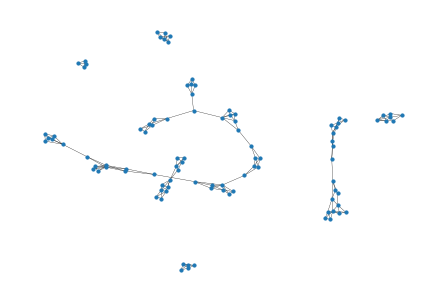

In [39]:
nx.draw(nx.Graph(gr), node_size=10, width=.3)

In [91]:
def laplacian_eigenmap(data_matrix, N, K, sig):
    gr = kneighbors_graph(data_matrix, N)
    gr = nx.Graph(gr)
    lap = nx.laplacian_matrix(gr).todense()
    eigs = np.linalg.eig(lap)
    
    e_vals = eigs[0]
    e_vec_idxs = []
    for i in range(K):
        max_idx = np.where(e_vals == e_vals.max())
        e_vec_idxs.append(max_idx)
        e_vals[max_idx] = -1e10
    
    print(eigs[1].shape)
    return eigs[1][:,e_vec_idxs].reshape((data_matrix.shape[0],K))
    

In [95]:
eig_map = laplacian_eigenmap(im_matrix[:100], N=3, K=3, sig=0.5)

(100, 100)


<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


1a) Use your clustering code to produce clusters of your face dataset. Tweak the hyperparameters of your clustering algorithm until it produces clusters that look reasonable. You should examine your clusters by looking at examples from each cluster. Write a short qualitative description of what each cluster appears to represent. 

In [98]:
# calculated above: agglomerative clustering assignments for entire image dataset:
agglom_clusters = assignments

# also from above, kmeans clustering assignments
kmeans_clusters = kmeans_assignments

In [99]:
# looking at agglomerative clusters:
clusters = np.unique(agglom_clusters)

In [128]:
cluster1_idx = np.where(agglom_clusters == clusters[0])[0]
cluster2_idx = np.where(agglom_clusters == clusters[1])[0]
cluster3_idx = np.where(agglom_clusters == clusters[2])[0]
cluster4_idx = np.where(agglom_clusters == clusters[3])[0]
cluster5_idx = np.where(agglom_clusters == clusters[4])[0]

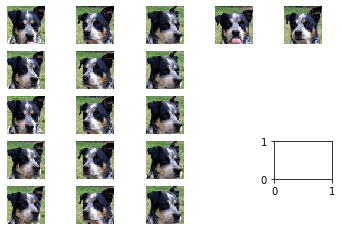

In [153]:
fig, ((ax1, ax6, ax11, ax16, ax21),
      (ax2, ax7, ax12, ax17, ax22),
      (ax3, ax8, ax13, ax18, ax23),
      (ax4, ax9, ax14, ax19, ax25),
      (ax5, ax10, ax15, ax20, ax25)) = plt.subplots(nrows=5, ncols=5)

axes = [[ax1, ax6, ax11, ax16, ax21],
      [ax2, ax7, ax12, ax17, ax22],
      [ax3, ax8, ax13, ax18, ax23],
      [ax4, ax9, ax14, ax19, ax25],
      [ax5, ax10, ax15, ax20, ax25]]
for row in axes:
    for ax in row:
        ax.axis('off')
    
ax1.matshow(ims[cluster1_idx[0]][0])
ax2.matshow(ims[cluster1_idx[1]][0])
ax3.matshow(ims[cluster1_idx[2]][0])
ax4.matshow(ims[cluster1_idx[3]][0])
ax5.matshow(ims[cluster1_idx[4]][0])

ax6.matshow(ims[cluster2_idx[0]][0])
ax7.matshow(ims[cluster2_idx[1]][0])
ax8.matshow(ims[cluster2_idx[2]][0])
ax9.matshow(ims[cluster2_idx[3]][0])
ax10.matshow(ims[cluster2_idx[4]][0])

ax11.matshow(ims[cluster3_idx[0]][0])
ax12.matshow(ims[cluster3_idx[1]][0])
ax13.matshow(ims[cluster3_idx[2]][0])
ax14.matshow(ims[cluster3_idx[3]][0])
ax15.matshow(ims[cluster3_idx[4]][0])

# only a single image in last 2 clusters
ax16.matshow(ims[cluster4_idx[0]][0])

ax21.matshow(ims[cluster5_idx[0]][0])


Each column represents a cluster. The two columns that are not complete represent clusters that were only assigned a single image. Agglomeration took a very long time to run so I was not able to play around much with hyperparameters. That said, this behavior seemed to occur with each run. The single image in cluster 4 does seem to be quite different from all the other clusters/images providing some justification for it being a single image cluster.

In [154]:
clusters = np.unique(kmeans_clusters)

In [156]:
cluster1_idx = np.where(kmeans_clusters == clusters[0])[0]
cluster2_idx = np.where(kmeans_clusters == clusters[1])[0]
cluster3_idx = np.where(kmeans_clusters == clusters[2])[0]

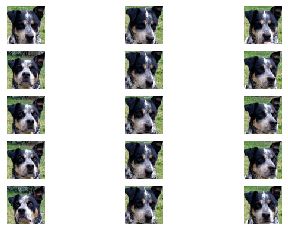

In [158]:
fig, ((ax1, ax6, ax11),
      (ax2, ax7, ax12),
      (ax3, ax8, ax13),
      (ax4, ax9, ax14),
      (ax5, ax10, ax15)) = plt.subplots(nrows=5, ncols=3)

axes = [[ax1, ax6, ax11],
      [ax2, ax7, ax12],
      [ax3, ax8, ax13],
      [ax4, ax9, ax14],
      [ax5, ax10, ax15]]
      
for row in axes:
    for ax in row:
        ax.axis('off')
    
ax1.matshow(ims[cluster1_idx[0]][0])
ax2.matshow(ims[cluster1_idx[1]][0])
ax3.matshow(ims[cluster1_idx[2]][0])
ax4.matshow(ims[cluster1_idx[3]][0])
ax5.matshow(ims[cluster1_idx[4]][0])

ax6.matshow(ims[cluster2_idx[0]][0])
ax7.matshow(ims[cluster2_idx[1]][0])
ax8.matshow(ims[cluster2_idx[2]][0])
ax9.matshow(ims[cluster2_idx[3]][0])
ax10.matshow(ims[cluster2_idx[4]][0])

ax11.matshow(ims[cluster3_idx[0]][0])
ax12.matshow(ims[cluster3_idx[1]][0])
ax13.matshow(ims[cluster3_idx[2]][0])
ax14.matshow(ims[cluster3_idx[3]][0])
ax15.matshow(ims[cluster3_idx[4]][0])


The kmeans clusters are less impressive. The middle cluster seems to represent a clear "looking down and to the right of the image" The other two clusters seem to have a bit of a trend but are less solidly a sinlge category. Perhaps a 4th or 5th cluster would fix this issue but may run into the same issue as the agglom clusters.

1b) Repeat 1a, but with the features which are output by your Laplacian Eigenmap embedder. Do these clusters look more reasonable? Why or why not?